# Trading Places
In this homework, you will use the BACI bilateral trade flows dataset to analyze trade flows for the world and, more specifically, for the country of __Uruguay__. You will also do a rudimentary analysis of what is referred to as the "gravity equation" from international trade theory.

1. Read in every year of available data (2012 to 2020) using Dask __(1 point)__
2. Descriptive Statistics: __(3 points)__
    
    a. In the year 2012, who were the top 10 countries with the most trading partners? What about the bottom 10?
    
    b. Using the designation [here]( https://www.foreign-trade.com/reference/hscode.htm), describe the trade volume of the whole dataset in terms of value and list the five highest value sectors in the entire sample period.

    c. Calculate the top 10 goods with the highest trade volume in the entire dataset in terms of:
    
        i. Value
    
        ii. Quantity
3. Country statistics: __(2 points)__

    a. Calculate the top 10 exports (in terms of value) of Uruguary in 2012.
    
    b. Using the aggregated categories, find the product category with the highest annual average value from 2012 to 2020 in Uruguary and plot imports and export of this category from 2012 to 2020.



4. The Gravity Equation Relationship __(6 points)__

    a. (2 point) Using the country shapefile, calculate the distance in kilometers between the centroid of Uruguay and all of its trading partners using haversine distance or Euclidean distance (depending on what projection you are using).
    
    b. (1 point) Create a scatterplot of distance and trade flow volume (quantity and value) in logarithm form.
    
    c. (1 point) Calculate the correlations between trade volume and distance for both value and quantity. Interpret the correlations for each of these factors.
    
    d. (2 point) Using the designation you created in 2.d., for which sectors are trade flows (quantity) most strongly related to distance for this country?
    
5. Estimation __(5 points)__. For all the next questions, use the Uruguay trade flows (both exports and imports).
    
    a. (1 point) Create a function called "SSE_1p" that does the following given a scalar input $\beta$:
        1. subtracts the logarithm of quantity flow from the logarithm of distance times $\beta$.
$$ e = log(F_{ij}) - \beta log(d_{ij}) $$
        2. Squares the error.
        3. Returns the sum of the squared error. 
    b. (1 point) Plot the function from -1 to +3 with steps of .001, and then find the minimum of the function with the numpy function "argmin." Is it what you expected?
    
    c. (1 point) Time the above function, which is a grid search done sequentially. Then, use `dask` or `multiprocess` to  parallelize the function above and time it. What are the differences? 
    
    d. __EXTRA CREDIT (4 points)__ 
        i. Create another function called "SSE_2p" does the same as "SSE_1p" but instead takes a __vector__ as an argument:
        
 $$ e = log(F_{ij}) - \beta[0] - \beta[1] log(d_{ij})$$
 
        ii. Do a grid search with the first parameter range as 1500 to 2500 in steps of 10, and the second parameter range as -1 to +3 in steps of .005 as before. Do it using either `dask` or `multiprocessing`. What were your results? Comment on how or why the parameter on $log(d_{ij})$ is different than what you found in part 4b.
                NOTE: if it hits the lower bound, this means you should try a different parameter range to maximize over.
     
     e. (1 point) Now use the "econtools" package "reg" function to estimate the equation from part a but instead with a constant term. How much did the distance coefficient change?
     
     f. (1 point) Finally, merge in the GDP numbers from the World Bank and do the regression again, except this time adding the log of each country's GDP as covariates. How did the coefficient on distance change?
     
5. An analyst asks you "for which commodity sectors is distance most important in terms of exporting?" Describe what your economic intuition would say about the answer, and then also map out an analysis strategy for answering their question. As usual, describe: __(3 points)__
    - What data you would need.
    - How you would manipulate the data.
    - What analysis you would run.

In [1]:
import glob
import pandas as pd
from econtools.metrics import reg
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client, progress
import multiprocess as mp
import matplotlib.pyplot as plt
import json
import dask
import geopandas as gp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from multiprocessing.pool import ThreadPool, Pool
from dask import delayed
from dask import compute
import dask.bag as db
from dask.diagnostics import ProgressBar
import tabulate
import time

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = row
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Atharva Rajadnya
asr6@illinios.edu

In [2]:
client = Client(threads_per_worker=4, n_workers=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55357,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:55366,Total threads: 4
Dashboard: http://127.0.0.1:55368/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:55360,


# 1

Each row represents the trade flows from country  𝑖  to country  𝑗  for product  𝑘  in time  𝑡  in terms of either value or quantity.

In [3]:
# Reading all input files

file_pattern = 'BACI_*.csv'
df = dd.read_csv(file_pattern)
df

,t,i,j,k,v,q
npartitions=66,,,,,,
,int64,int64,int64,int64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


# 2.a

In [4]:
# Reading in text descriptions

products = pd.read_csv("product_codes_HS12_V202201.csv")
products = products.rename(columns={"code":"k"})

df_wdes = df.merge(products)

df_wdes.head()

,t,i,j,k,v,q,description,sector
0,2012,4,8,610469,2.734,0.044,"Trousers, bib and brace overalls, breeches and...",Textiles
1,2012,4,124,610469,0.059,0.002,"Trousers, bib and brace overalls, breeches and...",Textiles
2,2012,4,276,610469,0.024,0.001,"Trousers, bib and brace overalls, breeches and...",Textiles
3,2012,4,757,610469,1.020,0.017,"Trousers, bib and brace overalls, breeches and...",Textiles
4,2012,8,124,610469,0.358,0.011,"Trousers, bib and brace overalls, breeches and...",Textiles


In [5]:
# Merging in text descriptons

countries = pd.read_csv("country_codes_V202201.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv("country_codes_V202201.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

df_wdes.head()

,t,i,j,k,v,q,description,sector,name_i,name_j
0,2012,4,8,610469,2.734,0.044,"Trousers, bib and brace overalls, breeches and...",Textiles,Afghanistan,Albania
1,2012,4,8,630900,0.110,0.082,"Clothing: worn, and other worn articles",Textiles,Afghanistan,Albania
2,2012,20,8,910211,2.314,0.003,"Wrist-watches: electrically operated, with or ...",Miscellaneous,Andorra,Albania
3,2012,20,8,960810,0.144,NaN,Pens: ball point,Miscellaneous,Andorra,Albania
4,2012,20,8,80510,1.457,2.228,"Fruit, edible: oranges, fresh or dried",Vegetable Products,Andorra,Albania


In [6]:
# Printing top 10 countries with the least and most trading partners

df_2012 = df_wdes[df_wdes['t'] == 2012]

num_trading_partners = df_2012.groupby('i')['j'].nunique()

top_10_countries = num_trading_partners.compute().sort_values(ascending=False).head(10).to_frame(name='num_trading_partners')
bottom_10_countries = num_trading_partners.compute().sort_values().head(10).to_frame(name='num_trading_partners')

countries = pd.read_csv("country_codes_V202201.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})

top_10_countries = top_10_countries.reset_index().merge(countries[['i','name_i']], on='i')
bottom_10_countries = bottom_10_countries.reset_index().merge(countries[['i','name_i']], on='i')

In [7]:
print("Top 10 countries with the most trading partners in 2012:")
top_10_countries[['i','name_i', 'num_trading_partners']]

Top 10 countries with the most trading partners in 2012:


,i,name_i,num_trading_partners
0,842,"USA, Puerto Rico and US Virgin Islands",220
1,528,Netherlands,219
2,56,Belgium,219
3,826,United Kingdom,218
4,276,Germany,218
5,757,"Switzerland, Liechtenstein",218
6,410,Republic of Korea,218
7,764,Thailand,217
8,724,Spain,216
9,381,Italy,216


In [8]:
print("\nBottom 10 countries with the least trading partners in 2012:")
bottom_10_countries[['i','name_i', 'num_trading_partners']]


Bottom 10 countries with the least trading partners in 2012:


,i,name_i,num_trading_partners
0,535,"Bonaire, Saint Eustatius and Saba",1
1,534,Saint Maarten (Dutch part),4
2,728,South Sudan,11
3,574,Norfolk Islands,23
4,175,Mayotte,27
5,612,Pitcairn,28
6,876,Wallis and Futuna Islands,29
7,666,Saint Pierre and Miquelon,29
8,585,Palau,30
9,583,Federated State of Micronesia,33


# 2.b

In [9]:
# Trade volume of the whole dataset and top 5 sectors

trade_value_by_product = df_wdes.groupby('k')['v'].sum().compute()

# Trade volume

total_trade_value = trade_value_by_product.sum()
print("Total trade value of the whole dataset: $", '{:,.2f}'.format(total_trade_value))

Total trade value of the whole dataset: $ 157,743,581,288.62


In [10]:
# Top 5 sectors

sector_trade_volume = df_wdes.groupby('sector')['v'].sum()
sector_trade_volume = sector_trade_volume.compute()
top_sectors = sector_trade_volume.sort_values(ascending=False).head(5)

print("\nFive highest value sectors in the entire sample period:\n")
top_sectors


Five highest value sectors in the entire sample period:



sector
Machinery / Electrical           4.083484e+10
Mineral Products                 2.335537e+10
Transportation                   1.651292e+10
Chemicals & Allied Industries    1.488996e+10
Metals                           1.114140e+10
Name: v, dtype: float64

# 2.c

In [11]:
# Top 10 goods with highest trade volume

top10_value = df_wdes.groupby(['k', 'description'])['v'].sum().compute().nlargest(10)
top10_quantity = df_wdes.groupby(['k', 'description'])['q'].sum().compute().nlargest(10)

In [12]:
print("Top 10 goods by value:")
top10_value.to_frame()

Top 10 goods by value:


,,v
k,description,
270900,"Oils: petroleum oils and oils obtained from bituminous minerals, crude",9.619889e+09
271000,"Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils",6.443169e+09
710812,"Metals: gold, non-monetary, unwrought (but not powder)",2.831949e+09
300490,"Medicaments: consisting of mixed or unmixed products n.e.c. in heading no. 3004, for therapeutic or prophylactic uses, packaged for retail sale",2.457648e+09
870323,"Vehicles: spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc",2.434236e+09
851712,Telephones for cellular networks or for other wireless networks,2.371809e+09
854231,"Electronic integrated circuits: processors and controllers, whether or not combined with memories, converters, logic circuits, amplifiers, clock and timing circuits, or other circuits",1.792474e+09
854239,Electronic integrated circuits: n.e.c. in heading no. 8542,1.769884e+09
847130,"Automatic data processing machines: portable, weighing not more than 10kg, consisting of at least a central processing unit, a keyboard and a display",1.380602e+09


In [13]:
print("\nTop 10 goods by quantity:")
top10_quantity.to_frame()


Top 10 goods by quantity:


,,q
k,description,
270900,"Oils: petroleum oils and oils obtained from bituminous minerals, crude",1.928171e+10
260111,Iron ores and concentrates: non-agglomerated,1.203157e+10
271000,"Petroleum oils and oils from bituminous minerals, not crude: preparations n.e.c. containing by weight 70% or more of petroleum oils or oils from bituminous minerals: these being the basic constituents of the preparations: waste oils",1.044005e+10
270112,"Coal: bituminous, whether or not pulverised, but not agglomerated",8.775395e+09
220190,"Waters: other than mineral and aerated, (not containing added sugar or other sweetening matter nor flavoured), ice and snow",4.938093e+09
270119,"Coal: (other than anthracite and bituminous), whether or not pulverised but not agglomerated",3.950774e+09
271121,"Petroleum gases and other gaseous hydrocarbons: in gaseous state, natural gas",3.197916e+09
271111,"Petroleum gases and other gaseous hydrocarbons: liquefied, natural gas",3.157214e+09
251710,"Pebbles, gravel, broken or crushed stone: of a kind commonly used for concrete aggregates, for road metalling or for railway or other ballast, shingle and flint, whether or not heat-treated",1.770941e+09


# 3.a

In [14]:
# Top 10 exports of Uruguay in 2012

uruguay_2012 = df_wdes[(df_wdes['i'] == 858) & (df_wdes['t'] == 2012)]

product_trade_value = uruguay_2012.groupby('k')['v'].sum().compute()

top_10_exports = product_trade_value.nlargest(10).to_frame(name='trade_value').reset_index()
top_10_exports = top_10_exports.merge(products[['k', 'description']])

print("\nTop 10 exports of Uruguay in 2012:\n")
top_10_exports


Top 10 exports of Uruguay in 2012:



,k,trade_value,description
0,20230,994527.325,"Meat: of bovine animals, boneless cuts, frozen"
1,120190,678342.564,"Soya beans: other than seed, whether or not br..."
2,470329,472534.564,"Wood pulp: chemical wood pulp, soda or sulphat..."
3,100630,413552.853,"Cereals: rice, semi-milled or wholly milled, w..."
4,20130,368935.528,"Meat: of bovine animals, boneless cuts, fresh ..."
5,40690,240287.634,"Dairy produce: cheese (not grated, powdered or..."
6,330210,239338.165,Odoriferous substances and mixtures: of a kind...
7,40221,227614.665,"Dairy produce: milk and cream, concentrated, n..."
8,110710,194494.435,Malt: not roasted
9,392330,179189.320,"Plastics: carboys, bottles, flasks and similar..."


# 3.b

In [15]:
# Product category with highest annual average

uruguay_agg = df_wdes[df_wdes['i'] == 858].groupby(['sector', 't'])[['v', 'q']].sum().compute()

uruguay_agg['avg_value'] = uruguay_agg['v'] / (uruguay_agg.index.get_level_values('t').max() - uruguay_agg.index.get_level_values('t').min() + 1)

top_sector = uruguay_agg.groupby('sector')['avg_value'].mean().nlargest(1).index[0]

In [16]:
# Top sector

print("The top sector is")
top_sector

The top sector is


'Animal & Animal Products'

In [17]:
top_sector_data = uruguay_agg.loc[top_sector]
top_sector_data

,v,q,avg_value
t,,,
2012,2847292.065,730042.161,316365.785000
2013,2720797.881,660546.226,302310.875667
2014,3027571.202,720742.273,336396.800222
2015,2691733.958,730501.545,299081.550889
2016,2587455.625,784350.651,287495.069444
2017,2803722.223,809676.908,311524.691444
2018,3099659.267,884809.423,344406.585222
2019,3036708.778,743486.278,337412.086444
2020,2782393.436,736824.377,309154.826222


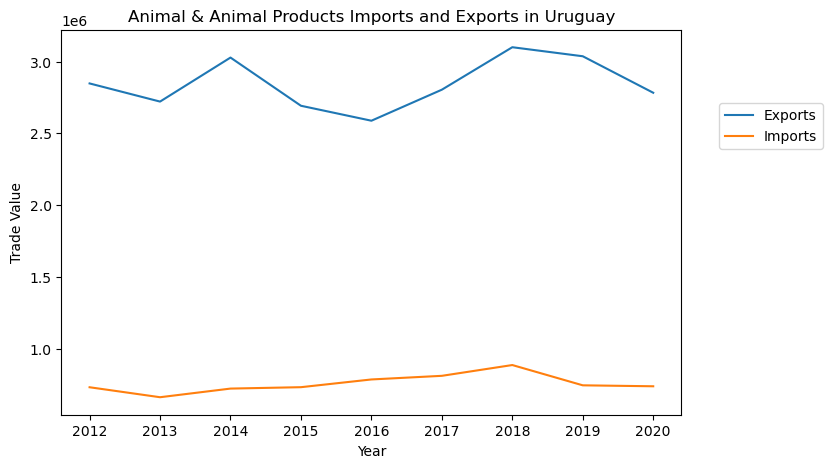

In [18]:
# Plot imports and exports of the top sector

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(top_sector_data.index.get_level_values('t'), top_sector_data['v'], label='Exports')
ax.plot(top_sector_data.index.get_level_values('t'), top_sector_data['q'], label='Imports')

ax.set_title(f"{top_sector} Imports and Exports in Uruguay")
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')

ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.75))

plt.show()

# 4.a

In [19]:
# Load country shapefile

country_shapefile = gp.read_file('World_Countries__Generalized_.shp')
uruguay_shapefile = country_shapefile[country_shapefile['COUNTRY'] == 'Uruguay']

uruguay_centroid = uruguay_shapefile.centroid.iloc[0]

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/947925171.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uruguay_centroid = uruguay_shapefile.centroid.iloc[0]


In [20]:
# Select all rows where Uruguay is the importer

uruguay_imports = df_wdes[df_wdes['j'] == 858]

# Group by exporting country code and select unique values
uruguay_trading_partners = uruguay_imports.groupby('i')['name_i'].first().compute().unique()

In [21]:
# Get centroids of trading partners

trading_partners_centroids = []
trading_partners_names = []
for name_i in uruguay_trading_partners:
    country_shape = country_shapefile[country_shapefile['COUNTRY'] == name_i]
    if not country_shape.empty:
        trading_partners_names.append(name_i)
        trading_partners_centroids.append(country_shape.centroid.iloc[0])
        
trading_partners_df = pd.DataFrame({'name_i': trading_partners_names,
                                    'centroid': trading_partners_centroids})

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc[0])
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_56173/1064503956.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trading_partners_centroids.append(country_shape.centroid.iloc

In [22]:
# Calculating the distance between centroids

distances = []
for centroid in trading_partners_centroids:
    row = [uruguay_centroid.x, uruguay_centroid.y, centroid.x, centroid.y]
    distance = haversine(row)
    distances.append(distance)

trading_partners_df['distance_km'] = distances
display_columns = ['name_i', 'distance_km']

trading_partners_df[display_columns]

,name_i,distance_km
0,Afghanistan,14702.668509
1,Albania,11317.256681
2,Algeria,9177.445637
3,Andorra,10226.737861
4,Antigua and Barbuda,5602.392346
...,...,...
183,Chad,9556.757833
184,Montenegro,11362.720815
185,Montserrat,5547.044611
186,Kiribati,10907.304229


# 4.b

In [23]:
# Take logarithm of distance and trade flow variables

uruguay_data = df_wdes[(df_wdes['j'] == 858)]

trading_partners_volume = uruguay_data.groupby('name_i')[['q', 'v']].sum().compute()

trading_partners_distance = trading_partners_df.set_index('name_i')['distance_km']
trading_partners_data = pd.merge(trading_partners_volume, trading_partners_distance, left_index=True, right_index=True)

trading_partners_data['log_q'] = np.log10(trading_partners_data['q'])
trading_partners_data['log_v'] = np.log10(trading_partners_data['v'])

trading_partners_data['log_distance_km'] = np.log10(trading_partners_data['distance_km'])

/Users/atharvarajadnya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


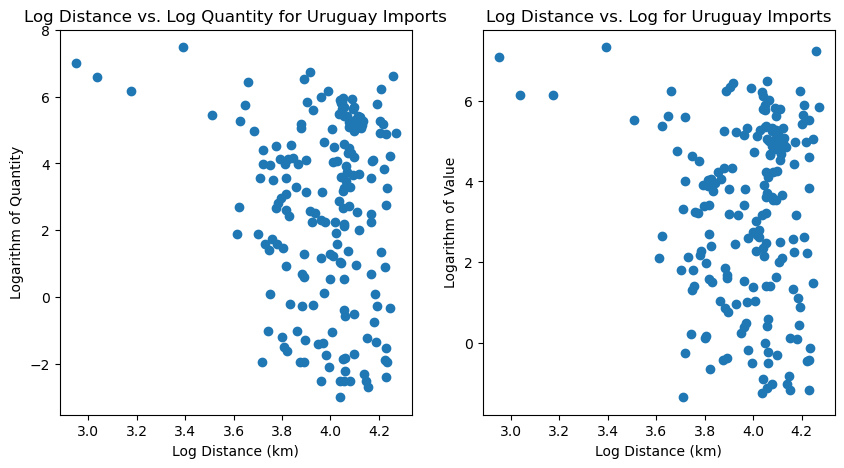

In [24]:
# Plotting the scatter plots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot log distance vs. logarithm of quantity
ax1.scatter(trading_partners_data['log_distance_km'], trading_partners_data['log_q'])
ax1.set_xlabel('Log Distance (km)')
ax1.set_ylabel('Logarithm of Quantity')
ax1.set_title('Log Distance vs. Log Quantity for Uruguay Imports')

# Plot log distance vs. logarithm of value
ax2.scatter(trading_partners_data['log_distance_km'], trading_partners_data['log_v'])
ax2.set_xlabel('Log Distance (km)')
ax2.set_ylabel('Logarithm of Value')
ax2.set_title('Log Distance vs. Log for Uruguay Imports')

plt.show()

# 4.c

In [25]:
# Corelations

trading_partners_data[['q', 'v', 'distance_km']].apply(np.log10).corr()

,q,v,distance_km
q,1.000000,0.973624,-0.145950
v,0.973624,1.000000,-0.095243
distance_km,-0.145950,-0.095243,1.000000


The correlation between distance and quantity is negative (-0.14), which means that as distance increases, the quantity of imports tends to decrease. This makes intuitive sense, as it is generally more difficult and expensive to transport goods over longer distances, so importers are likely to purchase fewer goods from countries that are farther away.

The correlation between distance and value is also negative (-0.09), which means that as distance increases, the value of imports tends to decrease. This makes sense for similar reasons as the correlation between distance and quantity. If it is more difficult and expensive to transport goods over longer distances, then importers are likely to purchase lower-value goods from countries that are farther away.

The correlation between quantity and value is positive (0.97), which means that as the quantity of imports increases, the value of imports tends to increase as well. This also makes sense, as higher quantities of goods typically correspond to higher total values of those goods.

# 4.d

In [26]:
# Trade flow vs distance for a sector

uruguay_data_sectors=uruguay_data.groupby(["sector","name_i"])["q"].sum().compute()
uruguay_data_sectors

sector                             name_i                                   
 Stone / Glass                     Argentina                                    648858.260
                                   Australia                                         9.326
                                   Austria                                         124.339
                                   Bangladesh                                        2.103
                                   Belgium                                        2021.685
                                                                                   ...    
Raw Hides, Skins, Leather, & Furs  Egypt                                             0.000
Transportation                     Tokelau                                           0.000
                                   Turkmenistan                                      0.000
                                   Zambia                                            0.070
Wood & Wood P

In [27]:
# Merging data frames

uruguay_dist_sect = pd.merge(trading_partners_df[['name_i', 'distance_km']], uruguay_data_sectors.reset_index(), on='name_i')
uruguay_dist_sect

,name_i,distance_km,sector,q
0,Afghanistan,14702.668509,Footwear / Headgear,0.732
1,Afghanistan,14702.668509,Transportation,0.161
2,Afghanistan,14702.668509,Machinery / Electrical,0.610
3,Afghanistan,14702.668509,Metals,0.050
4,Afghanistan,14702.668509,"Raw Hides, Skins, Leather, & Furs",0.000
...,...,...,...,...
1604,Chad,9556.757833,Plastics / Rubbers,0.016
1605,Montenegro,11362.720815,Machinery / Electrical,0.003
1606,Montserrat,5547.044611,Machinery / Electrical,0.098
1607,Kiribati,10907.304229,Machinery / Electrical,0.001


In [28]:
# Calculate correlation coefficient for each sector

sectors = uruguay_dist_sect['sector'].unique()

correlations = []
for sector in sectors:
    df = uruguay_dist_sect[uruguay_dist_sect['sector'] == sector]
    corr = np.corrcoef(df['distance_km'], df['q'])[0, 1]
    correlations.append((sector, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print('Top sectors with strongest relationship between distance and trade flows:\n')

for sector, corr in correlations[:]:
    print(f'{sector}: {corr:.2f}')

Top sectors with strongest relationship between distance and trade flows:

Vegetable Products: -0.40
Foodstuffs: -0.36
Wood & Wood Products: -0.31
 Stone / Glass: -0.28
Animal & Animal Products: -0.27
Mineral Products: -0.27
Raw Hides, Skins, Leather, & Furs: -0.20
Metals: -0.16
Footwear / Headgear: 0.15
Plastics / Rubbers: -0.08
Machinery / Electrical: 0.08
Transportation: -0.08
Miscellaneous: -0.05
Chemicals & Allied Industries: -0.04
Textiles: 0.02


The negative correlation coefficients indicate that there is a negative relationship between distance and trade flows for the top sectors. In other words, as the distance between Uruguay and its trading partners increases, the quantity of trade flows tends to decrease. This suggests that distance is an important factor in determining trade patterns for these sectors, possibly due to transportation costs, logistics, or other related factors.

# 5.a

In [29]:
# Creating function

uruguay_SSE = uruguay_dist_sect[uruguay_dist_sect['q'] > 0]
distances = uruguay_SSE['distance_km']
flows = uruguay_SSE['q']

def SSE_1p(beta):
    e = [np.log(flows[i]) - beta * np.log(distances[i]) for i in uruguay_SSE.index]
    return np.sum(np.array(e) ** 2)

# 5.b

In [30]:
# Calculating SSE values

beta = np.arange(-1, 3, 0.001)

start_time = time.time()

result = [SSE_1p(x) for x in beta]

end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

# Execution time: 43.72 seconds

Execution time: 43.72 seconds


In [31]:
# Minimum beta

print("The minimum beta is ")

-1 + np.argmin(result) * 0.001

The minimum beta is 


0.393

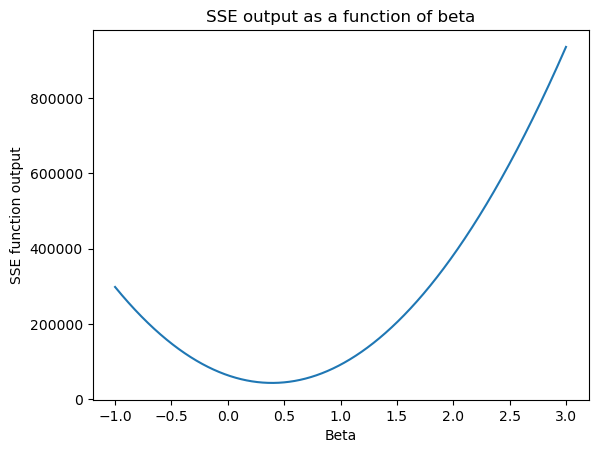

In [32]:
# Plotting

plt.plot(beta, result)

plt.xlabel('Beta')
plt.ylabel('SSE function output')
plt.title('SSE output as a function of beta')
plt.show()

# 5.c

In [33]:
# Parallel processing using multiprocess

export = {'q': flows, 'distance_km': distances}  
export_df = pd.DataFrame(export)
export_df.to_csv("export_df.csv", index=False)

In [34]:
# Defining function

def SSE_1p_parallel(beta):
    import_df = pd.read_csv("export_df.csv")
    e = [np.log(import_df.q[i]) - beta * np.log(import_df.distance_km[i]) for i in import_df.index]
    return np.sum(np.array(e) ** 2)

In [35]:
# Timing the function

start_time = time.time()

pool = mp.Pool(4)
result_parallel = pool.map(SSE_1p_parallel,beta)
pool.close()
pool.join()

end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

# Execution time: 28.27 seconds

Execution time: 28.27 seconds


In [36]:
# Parallel computing using dask

SSE_d = dask.delayed(SSE_1p)

SSE=[]

for x in beta:
    y = SSE_d(x)
    SSE.append(y)

In [37]:
# Timing the function

start_time = time.time()

result_dask = dask.compute(SSE)

end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

# Execution time: 32.81 seconds

Execution time: 32.81 seconds


# 5.d (extra credit)

In [38]:
# Creating function

def SSE_2p_parallel(beta):
    import_df = pd.read_csv("export_df.csv")
    e = [np.log(import_df.q[i]) - beta[0] - beta[1] * np.log(import_df.distance_km[i])  for i in import_df.index]
    return np.sum(np.array(e) ** 2)

def SSE_2p(row):
    beta0, beta1 = row
    e = [np.log(flows[i]) - beta0 - beta1 * np.log(distances[i]) for i in uruguay_SSE.index]
    return np.sum(np.array(e) ** 2)

In [39]:
# Preparing inputs

x0 = np.arange(1500, 2500, 10)
x1 = np.arange(-1, 3, 0.005)

size = len(x1) * len(x0)

x01 = np.empty(shape = (size,2), dtype = 'object')

for i in range(len(x0)):
    idx = len(x1) * i
    for j in range(len(x1)):
        x01[idx,0] = x0[i]
        x01[idx,1] = x1[j]
        idx+=1

In [40]:
# Timing the function

start_time = time.time()

pool = mp.Pool(4)
result_parallel = pool.map(SSE_2p_parallel,x01)
pool.close()
pool.join()

end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

# Execution time: 676.89 seconds

Execution time: 676.89 seconds


In [41]:
# Check if parameter range is correct

np.argmin(result_parallel)

0

This went out of bounds, so we need to try a different parameter range.

In [42]:
# Preparing inputs

x0 = np.arange(-500, 1000, 10)
x1 = np.arange(-1, 3, 0.005)

size = len(x1) * len(x0)

x01 = np.empty(shape = (size,2), dtype = 'object')

for i in range(len(x0)):
    idx = len(x1) * i
    for j in range(len(x1)):
        x01[idx,0] = x0[i]
        x01[idx,1] = x1[j]
        idx+=1

In [43]:
# Timing the function

start_time = time.time()

pool = mp.Pool(4)
result_parallel = pool.map(SSE_2p_parallel,x01)
pool.close()
pool.join()

end_time = time.time()
print("Execution time: {:.2f} seconds".format(end_time - start_time))

# Execution time: 1051.70 seconds

Execution time: 1051.70 seconds


In [44]:
# Check if parameter range is correct

np.argmin(result_parallel)

# 40861

40861

This is within bounds.

In [45]:
# Extracting beta0 and beta1

idxmin = np.argmin(result_parallel)
ix0 = x0[0] + idxmin // len(x1) * 10
ix1 = x1[0]+ idxmin % len(x1) * 0.005
[ix0, ix1]

# [10, -0.6950000000000001]

[10, -0.6950000000000001]

The distance parameter dropped from 1 to almost -0.695. A negative change in the distance parameter would indicate that the distance between countries is having a stronger negative impact on trade flows than before.

# 5.e

In [46]:
# Using econtools package

log_df = np.log(export_df)
y = 'q'
x = 'distance_km'

ols = reg(log_df, y, x, addcons=True)
ols

Dependent variable:	q
N:			1560
R-squared:		0.0235
Estimation method:	OLS
VCE method:		Standard (Homosk.)
             coeff    se      t   p>t CI_low CI_high
distance_km -1.494 0.244 -6.119 0.000 -1.973  -1.015
_cons       17.338 2.240  7.741 0.000 12.944  21.731

The regression results indicate a statistically significant negative correlation between distance and the dependent variable q. As distance increases, the value of q tends to decrease. However, the explanatory power of the distance variable alone is quite low.

# 5.f

In [47]:
# Importing GDP

gdp = pd.read_csv('GDP_WDI.csv', na_values='..')
gdp.dropna(subset=['Country Name'], inplace=True)

gdp_mean = gdp.iloc[:,5:14]
gdp["log_avg_GDP"] = np.log(gdp_mean.mean(axis=1))
gdp = gdp.iloc[:,[2,3,14]]
gdp = gdp.rename(columns={'Country Name': 'name_i'})

gdp

,name_i,Country Code,log_avg_GDP
0,Afghanistan,AFG,23.682357
1,Albania,ALB,23.313835
2,Algeria,DZA,25.916483
3,American Samoa,ASM,20.296407
4,Andorra,AND,21.851212
...,...,...,...
261,Sub-Saharan Africa,SSF,28.174039
262,Sub-Saharan Africa (excluding high income),SSA,28.173248
263,Sub-Saharan Africa (IDA & IBRD countries),TSS,28.174039
264,Upper middle income,UMC,30.698875


In [48]:
# Merging with distance and q dataframe

gdp_merge = pd.merge(uruguay_dist_sect, gdp, on = 'name_i')

gdp_merge

,name_i,distance_km,sector,q,Country Code,log_avg_GDP
0,Afghanistan,14702.668509,Footwear / Headgear,0.732,AFG,23.682357
1,Afghanistan,14702.668509,Transportation,0.161,AFG,23.682357
2,Afghanistan,14702.668509,Machinery / Electrical,0.610,AFG,23.682357
3,Afghanistan,14702.668509,Metals,0.050,AFG,23.682357
4,Afghanistan,14702.668509,"Raw Hides, Skins, Leather, & Furs",0.000,AFG,23.682357
...,...,...,...,...,...,...
1489,Chad,9556.757833,Machinery / Electrical,0.003,TCD,23.167480
1490,Chad,9556.757833,Plastics / Rubbers,0.016,TCD,23.167480
1491,Montenegro,11362.720815,Machinery / Electrical,0.003,MNE,22.269131
1492,Kiribati,10907.304229,Machinery / Electrical,0.001,KIR,19.043549


In [49]:
# Finding corelation

y = 'q'
x = ['log_avg_GDP', 'distance_km']
ols2 = reg(gdp_merge, y, x, addcons = True)
ols2 

Dependent variable:	q
N:			1474
R-squared:		0.0235
Estimation method:	OLS
VCE method:		Standard (Homosk.)
                  coeff         se      t   p>t       CI_low     CI_high
log_avg_GDP   36808.408   8262.972  4.455 0.000    20599.943   53016.873
distance_km     -20.703      4.250 -4.871 0.000      -29.039     -12.366
_cons       -657023.516 203621.569 -3.227 0.001 -1056443.103 -257603.929

The linear regression model with log_avg_GDP and distance_km as independent variables explains only 2.35% of the variation in the dependent variable q. log_avg_GDP has a positive coefficient of 36,808.408 and is statistically significant (p<0.001), meaning that a higher average GDP per capita is associated with higher export intensity (q). distance_km has a negative coefficient of -20.703 and is also statistically significant (p<0.001), meaning that a greater distance from Uruguay is associated with lower export intensity.

# 6

Economic intuition suggests that distance matters more for exporting sectors that have higher transportation costs, perishable goods, or are more dependent on timely delivery. Thus, commodity sectors such as agriculture, fresh seafood, and other perishable items might be more affected by distance than sectors like electronics or machinery.

To answer the questions, we would need data on the exports of various commodity sectors, the distance from the exporting country to the importing country, and the transportation costs associated with each sector. 

The following is an analysis strategy that could be used to answer the question:

- Identify a dataset that contains information on the exports of different commodity sectors, the countries of origin and destination, and the distance between them. The dataset should also include information on transportation costs, if available.
- Manipulate the data by aggregating the exports by sector and country, and calculate the average distance for each sector. We could also calculate the average transportation costs for each sector, if available.
- Run a regression analysis to estimate the relationship between the average distance and exports for each sector. We could control for other factors that might affect exports, such as GDP, population, or trade agreements.
- Interpret the results and draw conclusions about which commodity sectors are most affected by distance in terms of exporting.

Alternatively, we could also use a gravity model approach, which is a common technique used in international trade analysis. This involves estimating the relationship between exports and the distance between countries, using a combination of data on trade flows, country characteristics, and transportation costs. We could estimate separate gravity models for each commodity sector, and compare the results to identify which sectors are most affected by distance.